Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3857 - val_loss: 0.1910
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1813 - val_loss: 0.1555
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1500 - val_loss: 0.1321
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1304 - val_loss: 0.1199
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1191 - val_loss: 0.1116
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1114 - val_loss: 0.1056
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1058 - val_loss: 0.1015
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1019 - val_loss: 0.0990
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0995 - val_loss: 0.0967
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0974 - val_loss: 0.0953
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0963 - val_loss: 0.0944
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

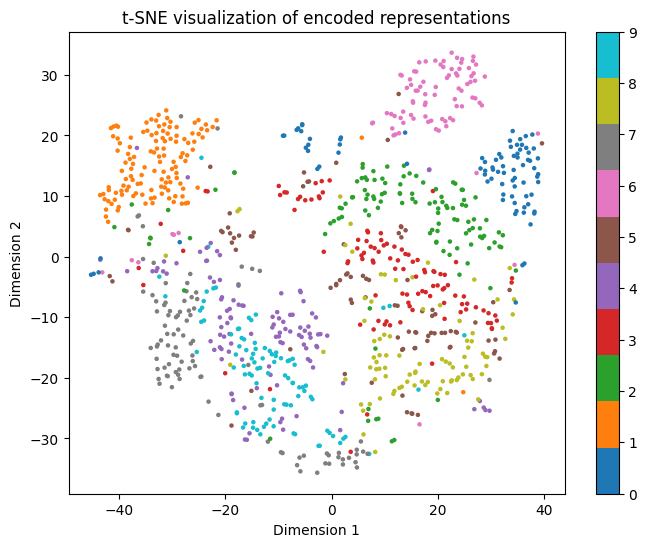

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from sklearn.manifold import TSNE

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input images from [0, 255] to [0, 1] and flatten them
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Define the dimensions of the encoding and input layer
input_dim = x_train.shape[1]
encoding_dim = 32  # Size of the encoded representation

# Define the input placeholder
input_img = Input(shape=(input_dim,))

# Define the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# Define the decoded reconstruction of the input
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Create the autoencoder model
autoencoder = Model(input_img, decoded)

# Create the encoder model
encoder = Model(input_img, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# Encode some test images to get the latent space representations
encoded_imgs = encoder.predict(x_test)

# Visualize the encoded (latent space) representations using t-SNE
def plot_encoded_space(encoded_data, labels, num_points=1000):
    # Use TSNE to reduce the dimensionality to 2D
    tsne = TSNE(n_components=2, random_state=42)
    reduced_encoded_data = tsne.fit_transform(encoded_data[:num_points])
    
    # Plot the encoded representations with color-coding for labels
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_encoded_data[:, 0], reduced_encoded_data[:, 1], c=labels[:num_points], cmap='tab10', s=5)
    plt.colorbar(scatter)
    plt.title("t-SNE visualization of encoded representations")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

# Plot the encoded space (latent space) of test images
plot_encoded_space(encoded_imgs, y_test)


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Add, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from sklearn.manifold import TSNE
import tensorflow as tf

# Positional encoding function
def positional_encoding(seq_len, model_dim):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(model_dim)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(model_dim))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return angle_rads[np.newaxis, ...]

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the input images from [0, 255] to [0, 1] and flatten them
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
seq_len = x_train.shape[1]  # 784 for flattened images

# Hyperparameters
d_model = 128  # Model dimensionality (must be consistent for residuals)
num_heads = 4  # Number of attention heads
dropout_rate = 0.1  # Dropout rate
encoding_dim = 32  # Bottleneck size, compressed representation

# Define the input placeholder
input_img = Input(shape=(seq_len,))

# Add positional encoding
pos_encoding = positional_encoding(seq_len, d_model)
pos_embed = tf.convert_to_tensor(pos_encoding, dtype=tf.float32)

# Ensure the positional encoding is broadcasted correctly to match the batch size
x = Dense(d_model)(input_img)  # Transform input to d_model dimensions
x += tf.broadcast_to(pos_embed, tf.shape(x))  # Broadcast positional encoding to match input

# Encoder block (Transformer encoder)
for _ in range(2):  # 2 layers of Transformer encoder
    # Multi-head attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    x = Add()([x, attn_output])  # Residual connection
    x = LayerNormalization()(x)

    # Feed-forward network
    ffn_output = Dense(d_model, activation='relu')(x)
    ffn_output = Dense(d_model)(ffn_output)  # Output must match d_model for residuals
    ffn_output = Dropout(dropout_rate)(ffn_output)
    x = Add()([x, ffn_output])  # Residual connection
    x = LayerNormalization()(x)

# Latent space (compressed representation)
encoded = Dense(encoding_dim, activation='relu')(x)  # Bottleneck layer outside of Transformer

# Decoder block (Transformer-like decoder)
for _ in range(2):  # 2 layers of Transformer decoder
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)

    # Feed-forward network
    ffn_output = Dense(d_model, activation='relu')(x)
    ffn_output = Dense(d_model)(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    x = Add()([x, ffn_output])
    x = LayerNormalization()(x)

# Flatten the output of the decoder to match the input shape
x = Flatten()(x)

# Final reconstruction of the input image
decoded = Dense(seq_len, activation='sigmoid')(x)  # Output must match original input shape

# Create the autoencoder model
autoencoder = Model(input_img, decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(x_train, x_train,
                epochs=1,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# Create an encoder model to extract the latent space representation
encoder = Model(input_img, encoded)

# Encode some test images to get the latent space representations
encoded_imgs = encoder.predict(x_test)

# Visualize the encoded (latent space) representations using t-SNE
def plot_encoded_space(encoded_data, labels, num_points=1000):
    # Use TSNE to reduce the dimensionality to 2D
    tsne = TSNE(n_components=2, random_state=42)
    reduced_encoded_data = tsne.fit_transform(encoded_data[:num_points])
    
    # Plot the encoded representations with color-coding for labels
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_encoded_data[:, 0], reduced_encoded_data[:, 1], c=labels[:num_points], cmap='tab10', s=5)
    plt.colorbar(scatter)
    plt.title("t-SNE visualization of encoded representations")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

# Plot the encoded space (latent space) of test images
plot_encoded_space(encoded_imgs, y_test)


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [2]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import tkinter as tk
from PIL import Image, ImageTk
import threading
import queue
import time

# Define the autoencoder model
def build_autoencoder():
    input_img = Input(shape=(128, 128, 3))  # Adjusted for RGB images

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)  # Increased filters for RGB
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output 3 channels

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')  # Changed loss to MSE

    return autoencoder

# Initialize the autoencoder
autoencoder = build_autoencoder()

# Preprocess the frame for the autoencoder
def preprocess_frame(frame):
    resized = cv2.resize(frame, (128, 128))  # Resize to 128x128 for the autoencoder
    normalized = resized.astype('float32') / 255.0  # Normalize pixel values
    return np.expand_dims(normalized, axis=0)  # Shape: (1, 128, 128, 3)

# Postprocess the autoencoded frame for display
def postprocess_frame(frame):
    frame = np.squeeze(frame, axis=0)  # Remove batch dimension
    frame = (frame * 255).astype('uint8')  # Rescale pixel values
    return cv2.resize(frame, (640, 480))  # Resize to match original frame size for display

# Frame buffer
frame_queue = queue.Queue(maxsize=100)  # Adjust maxsize as needed

def training_thread(autoencoder, frame_queue, stop_event):
    while not stop_event.is_set():
        if not frame_queue.empty():
            # Retrieve a batch of frames
            batch = []
            while not frame_queue.empty() and len(batch) < 32:  # Batch size of 32
                frame = frame_queue.get()
                batch.append(frame)
            
            if batch:
                batch = np.vstack(batch)  # Shape: (batch_size, 128, 128, 3)
                # Train on the batch
                loss = autoencoder.train_on_batch(batch, batch)
                print(f"Training loss: {loss:.6f}")
        else:
            # If queue is empty, wait a bit
            time.sleep(0.01)

# Tkinter window
window = tk.Tk()
window.title("Live RGB Autoencoder Training")

# Capture video feed
cap = cv2.VideoCapture(0)

# Labels for the images
original_label = tk.Label(window)
original_label.grid(row=0, column=0, padx=10, pady=10)
decoded_label = tk.Label(window)
decoded_label.grid(row=0, column=1, padx=10, pady=10)

def update():
    ret, frame = cap.read()
    if ret:
        # Flip the frame horizontally for a mirror effect
        frame = cv2.flip(frame, 1)

        # Preprocess the frame for display (keep RGB)
        original_image = cv2.resize(frame, (640, 480))  # Resize to match display size
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Tkinter

        # Preprocess the frame for the autoencoder
        preprocessed_frame = preprocess_frame(frame)

        # Add to the frame queue for training
        if not frame_queue.full():
            frame_queue.put(preprocessed_frame)

        # Predict the autoencoded frame
        autoencoded_frame = autoencoder.predict(preprocessed_frame, verbose=0)

        # Postprocess the autoencoded frame for display
        decoded_image = postprocess_frame(autoencoded_frame)

        # Convert images to ImageTk for display in Tkinter
        original_image_pil = Image.fromarray(original_image)
        decoded_image_pil = Image.fromarray(decoded_image)
        original_image_tk = ImageTk.PhotoImage(image=original_image_pil)
        decoded_image_tk = ImageTk.PhotoImage(image=decoded_image_pil)

        # Update the labels with the new images
        original_label.config(image=original_image_tk)
        original_label.image = original_image_tk
        decoded_label.config(image=decoded_image_tk)
        decoded_label.image = decoded_image_tk

    window.after(10, update)  # Update the frame every 10ms

# Event to signal the training thread to stop
stop_event = threading.Event()

# Start the training thread
trainer = threading.Thread(target=training_thread, args=(autoencoder, frame_queue, stop_event))
trainer.start()

# Start the update loop
update()

# Define a function to handle window closure
def on_closing():
    print("Closing application...")
    stop_event.set()  # Signal the training thread to stop
    trainer.join()    # Wait for the training thread to finish
    cap.release()
    cv2.destroyAllWindows()
    window.destroy()

# Bind the window close event
window.protocol("WM_DELETE_WINDOW", on_closing)

# Start the Tkinter event loop
window.mainloop()


TclError: image "pyimage5573" doesn't exist

Training loss: 0.250000


In [3]:
import cv2 
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Add, Embedding, Reshape
from tensorflow.keras.models import Model
import tkinter as tk
from PIL import Image, ImageTk
import threading
import queue
import time

# Define the Transformer-based autoencoder model
def build_autoencoder():
    image_size = 128  # Input image size
    patch_size = 16   # Size of each patch
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [projection_dim * 2, projection_dim]
    transformer_layers = 4

    # Create patches from the input images
    class Patches(tf.keras.layers.Layer):
        def __init__(self, patch_size):
            super(Patches, self).__init__()
            self.patch_size = patch_size

        def call(self, images):
            batch_size = tf.shape(images)[0]
            patches = tf.image.extract_patches(
                images=images,
                sizes=[1, self.patch_size, self.patch_size, 1],
                strides=[1, self.patch_size, self.patch_size, 1],
                rates=[1, 1, 1, 1],
                padding='VALID',
            )
            patch_dims = patches.shape[-1]
            patches = tf.reshape(patches, [batch_size, -1, patch_dims])
            return patches

    # Encode patches with positional embeddings
    class PatchEncoder(tf.keras.layers.Layer):
        def __init__(self, num_patches, projection_dim):
            super(PatchEncoder, self).__init__()
            self.num_patches = num_patches
            self.projection = Dense(units=projection_dim)
            self.position_embedding = Embedding(
                input_dim=num_patches, output_dim=projection_dim
            )

        def call(self, patches):
            positions = tf.range(start=0, limit=self.num_patches, delta=1)
            encoded = self.projection(patches) + self.position_embedding(positions)
            return encoded

    input_shape = (image_size, image_size, 3)
    inputs = Input(shape=input_shape)

    # Create patches
    patches = Patches(patch_size)(inputs)

    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer encoder
    for _ in range(transformer_layers):
        # Layer normalization
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Multi-head attention
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection
        x2 = Add()([attention_output, encoded_patches])
        # Layer normalization
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = Dense(transformer_units[0], activation='relu')(x3)
        x3 = Dense(transformer_units[1], activation='relu')(x3)
        # Skip connection
        encoded_patches = Add()([x3, x2])

    # Decoder to reconstruct the image
    x = Dense(patch_size * patch_size * 3)(encoded_patches)
    x = Reshape((num_patches, patch_size, patch_size, 3))(x)

    # Function to combine patches back to image
    def combine_patches(patches, image_size, patch_size):
        batch_size = tf.shape(patches)[0]
        n_patches = image_size // patch_size
        patches = tf.reshape(patches, (batch_size, n_patches, n_patches, patch_size, patch_size, 3))
        patches = tf.transpose(patches, perm=[0, 1, 3, 2, 4, 5])
        patches = tf.reshape(patches, (batch_size, image_size, image_size, 3))
        return patches

    reconstructed = tf.keras.layers.Lambda(
        lambda x: combine_patches(x, image_size, patch_size))(x)

    # Build the model
    autoencoder = Model(inputs=inputs, outputs=reconstructed)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    return autoencoder

# Initialize the autoencoder
autoencoder = build_autoencoder()

# Preprocess the frame for the autoencoder
def preprocess_frame(frame):
    resized = cv2.resize(frame, (128, 128))
    normalized = resized.astype('float32') / 255.0
    return np.expand_dims(normalized, axis=0)

# Postprocess the autoencoded frame for display
def postprocess_frame(frame):
    frame = np.squeeze(frame, axis=0)
    frame = (frame * 255).astype('uint8')
    return cv2.resize(frame, (640, 480))

# Frame buffer
frame_queue = queue.Queue(maxsize=100)

def training_thread(autoencoder, frame_queue, stop_event):
    while not stop_event.is_set():
        if not frame_queue.empty():
            batch = []
            while not frame_queue.empty() and len(batch) < 8:  # Reduced batch size
                frame = frame_queue.get()
                batch.append(frame)
            if batch:
                batch = np.vstack(batch)
                loss = autoencoder.train_on_batch(batch, batch)
                print(f"Training loss: {loss:.6f}")
        else:
            time.sleep(0.01)

# Tkinter window
window = tk.Tk()
window.title("Live RGB Autoencoder Training with Transformer")

# Capture video feed
cap = cv2.VideoCapture(0)

# Labels for the images
original_label = tk.Label(window)
original_label.grid(row=0, column=0, padx=10, pady=10)
decoded_label = tk.Label(window)
decoded_label.grid(row=0, column=1, padx=10, pady=10)

# Add a Close button
close_button = tk.Button(window, text="Close", command=lambda: on_closing())
close_button.grid(row=1, column=0, columnspan=2, pady=10)

def update():
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        window.after(10, update)
        return
    else:
        print("Frame captured")

    frame = cv2.flip(frame, 1)

    # Preprocess the frame for display
    original_image = cv2.resize(frame, (640, 480))
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Preprocess the frame for the autoencoder
    preprocessed_frame = preprocess_frame(frame)

    # Add to the frame queue for training
    if not frame_queue.full():
        frame_queue.put(preprocessed_frame)

    # Predict the autoencoded frame
    autoencoded_frame = autoencoder.predict(preprocessed_frame, verbose=0)

    # Postprocess the autoencoded frame for display
    decoded_image = postprocess_frame(autoencoded_frame)

    # Convert images to ImageTk for display in Tkinter
    original_image_pil = Image.fromarray(original_image)
    decoded_image_pil = Image.fromarray(decoded_image)
    original_image_tk = ImageTk.PhotoImage(image=original_image_pil)
    decoded_image_tk = ImageTk.PhotoImage(image=decoded_image_pil)

    # Update the labels with the new images
    original_label.config(image=original_image_tk)
    original_label.image = original_image_tk
    decoded_label.config(image=decoded_image_tk)
    decoded_label.image = decoded_image_tk

    window.after(10, update)

# Event to signal the training thread to stop
stop_event = threading.Event()

# Start the training thread
trainer = threading.Thread(target=training_thread, args=(autoencoder, frame_queue, stop_event))
trainer.start()

# Start the update loop
update()

# Define a function to handle window closure
def on_closing():
    print("Closing application...")
    stop_event.set()
    trainer.join()
    cap.release()
    cv2.destroyAllWindows()
    window.destroy()

# Bind the window close event
window.protocol("WM_DELETE_WINDOW", on_closing)

# Start the Tkinter event loop
window.mainloop()


Frame captured


TclError: image "pyimage2917" doesn't exist

Training loss: 0.337553


: 

In [7]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Add, Embedding, Reshape
from tensorflow.keras.models import Model
import tkinter as tk
from PIL import Image, ImageTk
import threading
import queue
import time

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs Available: {len(gpus)}")
    for gpu in gpus:
        print(f" - {gpu}")
        # Optional: Limit GPU memory growth
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPUs available.")

# Define the Transformer-based autoencoder model
def build_autoencoder(image_size=128):
    patch_size = 16   # Size of each patch
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [projection_dim * 2, projection_dim]
    transformer_layers = 4

    # Create patches from the input images
    class Patches(tf.keras.layers.Layer):
        def __init__(self, patch_size):
            super(Patches, self).__init__()
            self.patch_size = patch_size

        def call(self, images):
            batch_size = tf.shape(images)[0]
            patches = tf.image.extract_patches(
                images=images,
                sizes=[1, self.patch_size, self.patch_size, 1],
                strides=[1, self.patch_size, self.patch_size, 1],
                rates=[1, 1, 1, 1],
                padding='VALID',
            )
            patch_dims = patches.shape[-1]
            patches = tf.reshape(patches, [batch_size, -1, patch_dims])
            return patches

    # Encode patches with positional embeddings
    class PatchEncoder(tf.keras.layers.Layer):
        def __init__(self, num_patches, projection_dim):
            super(PatchEncoder, self).__init__()
            self.num_patches = num_patches
            self.projection = Dense(units=projection_dim)
            self.position_embedding = Embedding(
                input_dim=num_patches, output_dim=projection_dim
            )

        def call(self, patches):
            positions = tf.range(start=0, limit=self.num_patches, delta=1)
            encoded = self.projection(patches) + self.position_embedding(positions)
            return encoded

    input_shape = (image_size, image_size, 3)
    inputs = Input(shape=input_shape)

    # Create patches
    patches = Patches(patch_size)(inputs)

    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer encoder
    for _ in range(transformer_layers):
        # Layer normalization
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Multi-head attention
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection
        x2 = Add()([attention_output, encoded_patches])
        # Layer normalization
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = Dense(transformer_units[0], activation='relu')(x3)
        x3 = Dense(transformer_units[1], activation='relu')(x3)
        # Skip connection
        encoded_patches = Add()([x3, x2])

    # Mark the latent space
    latent_space = encoded_patches

    # Decoder to reconstruct the image
    x = Dense(patch_size * patch_size * 3)(latent_space)
    x = Reshape((num_patches, patch_size, patch_size, 3))(x)

    # Function to combine patches back to image
    def combine_patches(patches, image_size, patch_size):
        batch_size = tf.shape(patches)[0]
        n_patches = image_size // patch_size
        patches = tf.reshape(patches, (batch_size, n_patches, n_patches, patch_size, patch_size, 3))
        patches = tf.transpose(patches, perm=[0, 1, 3, 2, 4, 5])
        patches = tf.reshape(patches, (batch_size, image_size, image_size, 3))
        return patches

    reconstructed = tf.keras.layers.Lambda(
        lambda x: combine_patches(x, image_size, patch_size))(x)

    # Build the autoencoder model
    autoencoder = Model(inputs=inputs, outputs=reconstructed)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    # Build the encoder model
    encoder = Model(inputs=inputs, outputs=latent_space)

    return autoencoder, encoder

# Initialize the autoencoder and encoder
autoencoder, encoder = build_autoencoder()

# Preprocess the frame for the autoencoder
def preprocess_frame(frame, image_size):
    resized = cv2.resize(frame, (image_size, image_size))
    normalized = resized.astype('float32') / 255.0
    return np.expand_dims(normalized, axis=0)

# Postprocess the autoencoded frame for display
def postprocess_frame(frame, image_size):
    frame = np.squeeze(frame, axis=0)
    frame = (frame * 255).astype('uint8')
    return frame

# Frame buffer
frame_queue = queue.Queue(maxsize=100)

def training_thread(autoencoder, frame_queue, stop_event):
    while not stop_event.is_set():
        if not frame_queue.empty():
            batch = []
            while not frame_queue.empty() and len(batch) < 8:
                frame = frame_queue.get()
                batch.append(frame)
            if batch:
                batch = np.vstack(batch)
                loss = autoencoder.train_on_batch(batch, batch)
                print(f"Training loss: {loss:.6f}")
        else:
            time.sleep(0.01)
    print("Training thread exiting...")

# Tkinter window
window = tk.Tk()
window.title("Live RGB Autoencoder Training with Transformer")

# Define the on_closing function before creating the button
def on_closing():
    print("Closing application...")
    stop_event.set()
    cap.release()
    # cv2.destroyAllWindows()  # Remove or comment out this line
    window.destroy()

# Capture video feed
cap = cv2.VideoCapture(0)

# Labels for the images
original_label = tk.Label(window)
original_label.grid(row=0, column=0, padx=10, pady=10)
decoded_label = tk.Label(window)
decoded_label.grid(row=0, column=1, padx=10, pady=10)

# Add a Close button
close_button = tk.Button(window, text="Close", command=on_closing)
close_button.grid(row=4, column=0, columnspan=2, pady=10)

# Add a label to display bandwidth information
bandwidth_label = tk.Label(window, text="Calculating bandwidth...")
bandwidth_label.grid(row=3, column=0, columnspan=2, pady=10)

# Available display sizes (width, height)
display_sizes = [(320, 240), (640, 480), (800, 600)]

# Tkinter variable to hold the selected display size
selected_display_size = tk.StringVar()
selected_display_size.set(f"{display_sizes[1][0]}x{display_sizes[1][1]}")  # Default size

# Function to update the selected display size
def update_display_size(*args):
    size_str = selected_display_size.get()
    width, height = map(int, size_str.split('x'))
    print(f"Selected display size: {width}x{height}")

# Add an OptionMenu to select display size
size_options = [f"{w}x{h}" for w, h in display_sizes]
size_menu = tk.OptionMenu(window, selected_display_size, *size_options, command=update_display_size)
size_menu.grid(row=1, column=0, columnspan=2, pady=10)

# Available image sizes for the autoencoder
image_sizes = [64, 128, 256, 512]

# Tkinter variable to hold the selected image size
selected_image_size = tk.IntVar()
selected_image_size.set(image_sizes[1])  # Default size

# Function to update the image size
def update_image_size(*args):
    global trainer  # Declare 'trainer' as global at the start
    size = selected_image_size.get()
    print(f"Selected image size: {size}")
    # Stop the training thread
    stop_event.set()
    trainer.join()
    # Rebuild the autoencoder and encoder with the new size
    global autoencoder, encoder
    autoencoder, encoder = build_autoencoder(image_size=size)
    # Clear the frame queue
    with frame_queue.mutex:
        frame_queue.queue.clear()
    # Restart the training thread
    stop_event.clear()
    trainer = threading.Thread(target=training_thread, args=(autoencoder, frame_queue, stop_event), daemon=True)
    trainer.start()


# Add an OptionMenu to select image size
image_size_menu = tk.OptionMenu(window, selected_image_size, *image_sizes, command=update_image_size)
image_size_menu.grid(row=2, column=0, columnspan=2, pady=10)

def update():
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        window.after(10, update)
        return

    frame = cv2.flip(frame, 1)

    # Get the selected display size
    size_str = selected_display_size.get()
    display_width, display_height = map(int, size_str.split('x'))

    # Get the selected image size for the autoencoder
    image_size = selected_image_size.get()

    # Preprocess the frame for display
    original_image = cv2.resize(frame, (display_width, display_height))
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Preprocess the frame for the autoencoder
    preprocessed_frame = preprocess_frame(frame, image_size)

    # Add to the frame queue for training
    if not frame_queue.full():
        frame_queue.put(preprocessed_frame)

    # Predict the autoencoded frame
    autoencoded_frame = autoencoder.predict(preprocessed_frame, verbose=0)

    # Get the latent representation
    latent_representation = encoder.predict(preprocessed_frame, verbose=0)

    # Calculate bandwidth
    latent_size_bits = latent_representation.size * 32  # bits (assuming float32)
    input_size_bits = preprocessed_frame.size * 32  # bits (since preprocessed_frame is float32)
    compression_ratio = input_size_bits / latent_size_bits if latent_size_bits != 0 else 0

    # Update the bandwidth label
    bandwidth_label.config(text=f"Latent Space Size: {latent_size_bits / 1024:.2f} Kb\n"
                                f"Compression Ratio: {compression_ratio:.2f}")

    # Postprocess the autoencoded frame for display
    decoded_image = postprocess_frame(autoencoded_frame, image_size)
    decoded_image = cv2.resize(decoded_image, (display_width, display_height))

    # Convert images to ImageTk for display in Tkinter
    original_image_pil = Image.fromarray(original_image)
    decoded_image_pil = Image.fromarray(decoded_image)
    original_image_tk = ImageTk.PhotoImage(image=original_image_pil)
    decoded_image_tk = ImageTk.PhotoImage(image=decoded_image_pil)

    # Update the labels with the new images
    original_label.config(image=original_image_tk)
    original_label.image = original_image_tk
    decoded_label.config(image=decoded_image_tk)
    decoded_label.image = decoded_image_tk

    window.after(10, update)

# Event to signal the training thread to stop
stop_event = threading.Event()

# Start the training thread
trainer = threading.Thread(target=training_thread, args=(autoencoder, frame_queue, stop_event), daemon=True)
trainer.start()

# Start the update loop
update()

# Bind the window close event
window.protocol("WM_DELETE_WINDOW", on_closing)

# Start the Tkinter event loop
window.mainloop()


GPUs Available: 1
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


RuntimeError: Physical devices cannot be modified after being initialized

In [8]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Add, Embedding, Reshape
from tensorflow.keras.models import Model
import tkinter as tk
from PIL import Image, ImageTk
import threading
import queue
import time
import os

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs Available: {len(gpus)}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPUs available.")

# Define the Transformer-based autoencoder model
def build_autoencoder(image_size=128):
    patch_size = 16   # Size of each patch
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [projection_dim * 2, projection_dim]
    transformer_layers = 4

    class Patches(tf.keras.layers.Layer):
        def __init__(self, patch_size):
            super(Patches, self).__init__()
            self.patch_size = patch_size

        def call(self, images):
            batch_size = tf.shape(images)[0]
            patches = tf.image.extract_patches(
                images=images,
                sizes=[1, self.patch_size, self.patch_size, 1],
                strides=[1, self.patch_size, self.patch_size, 1],
                rates=[1, 1, 1, 1],
                padding='VALID',
            )
            patch_dims = patches.shape[-1]
            patches = tf.reshape(patches, [batch_size, -1, patch_dims])
            return patches

    class PatchEncoder(tf.keras.layers.Layer):
        def __init__(self, num_patches, projection_dim):
            super(PatchEncoder, self).__init__()
            self.num_patches = num_patches
            self.projection = Dense(units=projection_dim)
            self.position_embedding = Embedding(
                input_dim=num_patches, output_dim=projection_dim
            )

        def call(self, patches):
            positions = tf.range(start=0, limit=self.num_patches, delta=1)
            encoded = self.projection(patches) + self.position_embedding(positions)
            return encoded

    input_shape = (image_size, image_size, 3)
    inputs = Input(shape=input_shape)

    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = Add()([attention_output, encoded_patches])
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        x3 = Dense(transformer_units[0], activation='relu')(x3)
        x3 = Dense(transformer_units[1], activation='relu')(x3)
        encoded_patches = Add()([x3, x2])

    latent_space = encoded_patches
    x = Dense(patch_size * patch_size * 3)(latent_space)
    x = Reshape((num_patches, patch_size, patch_size, 3))(x)

    def combine_patches(patches, image_size, patch_size):
        batch_size = tf.shape(patches)[0]
        n_patches = image_size // patch_size
        patches = tf.reshape(patches, (batch_size, n_patches, n_patches, patch_size, patch_size, 3))
        patches = tf.transpose(patches, perm=[0, 1, 3, 2, 4, 5])
        patches = tf.reshape(patches, (batch_size, image_size, image_size, 3))
        return patches

    reconstructed = tf.keras.layers.Lambda(
        lambda x: combine_patches(x, image_size, patch_size))(x)

    autoencoder = Model(inputs=inputs, outputs=reconstructed)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    encoder = Model(inputs=inputs, outputs=latent_space)

    return autoencoder, encoder

autoencoder, encoder = build_autoencoder()

def preprocess_frame(frame, image_size):
    resized = cv2.resize(frame, (image_size, image_size))
    normalized = resized.astype('float32') / 255.0
    return np.expand_dims(normalized, axis=0)

def postprocess_frame(frame, image_size):
    frame = np.squeeze(frame, axis=0)
    frame = (frame * 255).astype('uint8')
    return frame

frame_queue = queue.Queue(maxsize=100)

def training_thread(autoencoder, frame_queue, stop_event):
    while not stop_event.is_set():
        if not frame_queue.empty():
            batch = []
            while not frame_queue.empty() and len(batch) < 8:
                frame = frame_queue.get()
                batch.append(frame)
            if batch:
                batch = np.vstack(batch)
                loss = autoencoder.train_on_batch(batch, batch)
                print(f"Training loss: {loss:.6f}")
        else:
            time.sleep(0.01)
    print("Training thread exiting...")

window = tk.Tk()
window.title("Live RGB Autoencoder Training with Transformer")

def on_closing():
    print("Closing application...")
    stop_event.set()
    cap.release()
    window.destroy()

# Get the current working directory and check the video file exists
current_dir = os.getcwd()
video_path = os.path.join(current_dir, 'TopGun.mp4')  # Adjust to your file

# Check if the video file exists
if not os.path.exists(video_path):
    print(f"Video file not found: {video_path}")
else:
    print(f"Opening video: {video_path}")

cap = cv2.VideoCapture(video_path)

# Check if video capture is opened successfully
if not cap.isOpened():
    print("Error: Cannot open video file")

original_label = tk.Label(window)
original_label.grid(row=0, column=0, padx=10, pady=10)
decoded_label = tk.Label(window)
decoded_label.grid(row=0, column=1, padx=10, pady=10)

close_button = tk.Button(window, text="Close", command=on_closing)
close_button.grid(row=4, column=0, columnspan=2, pady=10)

bandwidth_label = tk.Label(window, text="Calculating bandwidth...")
bandwidth_label.grid(row=3, column=0, columnspan=2, pady=10)

display_sizes = [(320, 240), (640, 480), (800, 600)]
selected_display_size = tk.StringVar()
selected_display_size.set(f"{display_sizes[1][0]}x{display_sizes[1][1]}")

def update_display_size(*args):
    size_str = selected_display_size.get()
    width, height = map(int, size_str.split('x'))
    print(f"Selected display size: {width}x{height}")

size_options = [f"{w}x{h}" for w, h in display_sizes]
size_menu = tk.OptionMenu(window, selected_display_size, *size_options, command=update_display_size)
size_menu.grid(row=1, column=0, columnspan=2, pady=10)

image_sizes = [64, 128, 256, 512]
selected_image_size = tk.IntVar()
selected_image_size.set(image_sizes[1])

def update_image_size(*args):
    global trainer
    size = selected_image_size.get()
    print(f"Selected image size: {size}")
    stop_event.set()
    trainer.join()
    global autoencoder, encoder
    autoencoder, encoder = build_autoencoder(image_size=size)
    with frame_queue.mutex:
        frame_queue.queue.clear()
    stop_event.clear()
    trainer = threading.Thread(target=training_thread, args=(autoencoder, frame_queue, stop_event), daemon=True)
    trainer.start()

image_size_menu = tk.OptionMenu(window, selected_image_size, *image_sizes, command=update_image_size)
image_size_menu.grid(row=2, column=0, columnspan=2, pady=10)

def update():
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame or end of video. Restarting video.")
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Restart the video
        ret, frame = cap.read()

    frame = cv2.flip(frame, 1)
    size_str = selected_display_size.get()
    display_width, display_height = map(int, size_str.split('x'))
    image_size = selected_image_size.get()
    original_image = cv2.resize(frame, (display_width, display_height))
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    preprocessed_frame = preprocess_frame(frame, image_size)

    if not frame_queue.full():
        frame_queue.put(preprocessed_frame)

    autoencoded_frame = autoencoder.predict(preprocessed_frame, verbose=0)
    latent_representation = encoder.predict(preprocessed_frame, verbose=0)
    latent_size_bits = latent_representation.size * 32
    input_size_bits = preprocessed_frame.size * 32
    compression_ratio = input_size_bits / latent_size_bits if latent_size_bits != 0 else 0

    bandwidth_label.config(text=f"Latent Space Size: {latent_size_bits / 1024:.2f} Kb\n"
                                f"Compression Ratio: {compression_ratio:.2f}")

    decoded_image = postprocess_frame(autoencoded_frame, image_size)
    decoded_image = cv2.resize(decoded_image, (display_width, display_height))
    original_image_pil = Image.fromarray(original_image)
    decoded_image_pil = Image.fromarray(decoded_image)
    original_image_tk = ImageTk.PhotoImage(image=original_image_pil)
    decoded_image_tk = ImageTk.PhotoImage(image=decoded_image_pil)

    original_label.config(image=original_image_tk)
    original_label.image = original_image_tk
    decoded_label.config(image=decoded_image_tk)
    decoded_label.image = decoded_image_tk

    window.after(10, update)

stop_event = threading.Event()
trainer = threading.Thread(target=training_thread, args=(autoencoder, frame_queue, stop_event), daemon=True)
trainer.start()
update()
window.protocol("WM_DELETE_WINDOW", on_closing)
window.mainloop()


Opening video: /mnt/c/Users/keplarV4/Downloads/Github/Graduate School/Semantic-Communication-Robot/TopGun.mp4


2024-10-05 00:37:27.919500: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_129', 4 bytes spill stores, 4 bytes spill loads

2024-10-05 00:37:28.050183: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_129', 12 bytes spill stores, 12 bytes spill loads

E0000 00:00:1728103048.242176   87365 gpu_command_buffer.cc:138] Failed to destroy GPU graph: Failed to destroy CUDA graph: CUDA_ERROR_INVALID_VALUE: invalid argument
2024-10-05 00:37:28.242410: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INTERNAL: Failed to end stream capture: CUDA_ERROR_STREAM_CAPTURE_INVALIDATED: operation failed due to a previous error during capture
	 [[{{node StatefulPartitionedCall}}]]
Exception in Tkinter callback
Traceback (most recent call last):
  Fil

Selected image size: 256
Selected image size: 512
Training thread exiting...
Closing application...
Training thread exiting...


In [5]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import tkinter as tk
from PIL import Image, ImageTk
import threading
import queue
import time
import os  # Import os to work with file paths

# Define the autoencoder model
def build_autoencoder():
    input_img = Input(shape=(128, 128, 3))  # Adjusted for RGB images

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    return autoencoder

# Initialize the autoencoder
autoencoder = build_autoencoder()

# Preprocess the frame for the autoencoder
def preprocess_frame(frame):
    resized = cv2.resize(frame, (128, 128))  # Resize to 128x128 for the autoencoder
    normalized = resized.astype('float32') / 255.0  # Normalize pixel values
    return np.expand_dims(normalized, axis=0)  # Shape: (1, 128, 128, 3)

# Postprocess the autoencoded frame for display
def postprocess_frame(frame):
    frame = np.squeeze(frame, axis=0)  # Remove batch dimension
    frame = (frame * 255).astype('uint8')  # Rescale pixel values
    return cv2.resize(frame, (640, 480))  # Resize to match original frame size for display

# Frame buffer
frame_queue = queue.Queue(maxsize=100)  # Adjust maxsize as needed

def training_thread(autoencoder, frame_queue, stop_event):
    while not stop_event.is_set():
        if not frame_queue.empty():
            # Retrieve a batch of frames
            batch = []
            while not frame_queue.empty() and len(batch) < 32:  # Batch size of 32
                frame = frame_queue.get()
                batch.append(frame)

            if batch:
                batch = np.vstack(batch)  # Shape: (batch_size, 128, 128, 3)
                # Train on the batch
                loss = autoencoder.train_on_batch(batch, batch)
                print(f"Training loss: {loss:.6f}")
        else:
            # If queue is empty, wait a bit
            time.sleep(0.01)

# Tkinter window
window = tk.Tk()
window.title("Live RGB Autoencoder Training")

# Get the current working directory and check if the video file exists
current_dir = os.getcwd()
video_path = os.path.join(current_dir, 'TopGun.mp4')  # Adjust to your file

if not os.path.exists(video_path):
    print(f"Error: Video file not found at {video_path}")
    exit()
else:
    print(f"Opening video: {video_path}")

# Capture video from the file
cap = cv2.VideoCapture(video_path)

# Check if video capture is opened successfully
if not cap.isOpened():
    print("Error: Cannot open video file")
    exit()

# Labels for the images
original_label = tk.Label(window)
original_label.grid(row=0, column=0, padx=10, pady=10)
decoded_label = tk.Label(window)
decoded_label.grid(row=0, column=1, padx=10, pady=10)

def update():
    ret, frame = cap.read()
    if not ret:
        # If video ends or frame can't be grabbed, restart the video
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        ret, frame = cap.read()

    if ret:
        # Flip the frame horizontally for a mirror effect
        frame = cv2.flip(frame, 1)

        # Preprocess the frame for display (keep RGB)
        original_image = cv2.resize(frame, (640, 480))  # Resize to match display size
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Tkinter

        # Preprocess the frame for the autoencoder
        preprocessed_frame = preprocess_frame(frame)

        # Add to the frame queue for training
        if not frame_queue.full():
            frame_queue.put(preprocessed_frame)

        # Predict the autoencoded frame
        autoencoded_frame = autoencoder.predict(preprocessed_frame, verbose=0)

        # Postprocess the autoencoded frame for display
        decoded_image = postprocess_frame(autoencoded_frame)

        # Convert images to ImageTk for display in Tkinter
        original_image_pil = Image.fromarray(original_image)
        decoded_image_pil = Image.fromarray(decoded_image)
        original_image_tk = ImageTk.PhotoImage(image=original_image_pil)
        decoded_image_tk = ImageTk.PhotoImage(image=decoded_image_pil)

        # Update the labels with the new images
        original_label.config(image=original_image_tk)
        original_label.image = original_image_tk
        decoded_label.config(image=decoded_image_tk)
        decoded_label.image = decoded_image_tk

    window.after(10, update)  # Update the frame every 10ms

# Event to signal the training thread to stop
stop_event = threading.Event()

# Start the training thread
trainer = threading.Thread(target=training_thread, args=(autoencoder, frame_queue, stop_event))
trainer.start()

# Start the update loop
update()

# Define a function to handle window closure
def on_closing():
    print("Closing application...")
    stop_event.set()  # Signal the training thread to stop
    trainer.join()    # Wait for the training thread to finish
    cap.release()
    cv2.destroyAllWindows()
    window.destroy()

# Bind the window close event
window.protocol("WM_DELETE_WINDOW", on_closing)

# Start the Tkinter event loop
window.mainloop()


Opening video: /mnt/c/Users/keplarV4/Downloads/Github/Graduate School/Semantic-Communication-Robot/TopGun.mp4
Training loss: 0.112038
Training loss: 0.135285
Training loss: 0.124257
Closing application...
Training loss: 0.122825


In [2]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs Available: {len(gpus)}")
    for gpu in gpus:
        print(f" - {gpu}")
        # Optional: Limit GPU memory growth
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPUs available.")


GPUs Available: 1
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-10-05 00:23:37.973609: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-05 00:23:37.980675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 00:23:37.988695: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 00:23:37.991118: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-05 00:23:37.997228: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1


I0000 00:00:1728102219.604112   24877 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728102219.623934   24877 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728102219.623968   24877 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
